In [1]:
import numpy as np
import pandas as pd

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

#to avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = '/Users/alexandr/Desktop/BERT/train.csv'
test ='/Users/alexandr/Desktop/BERT/test.csv'
sample_subbmission = '/Users/alexandr/Desktop/BERT/sample_submission.csv'
test_labels = '/Users/alexandr/Desktop/BERT/test_labels.csv'

In [3]:
train_data = pd.read_csv(train)
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
test_values = pd.read_csv(test)
#test_values = test_values['comment_text'].tolist()
test_values

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [5]:
test_labels = pd.read_csv(test_labels)
print(test_labels.shape)
test_labels = test_labels[
    (test_labels["toxic"] != -1) &
    (test_labels["severe_toxic"] != -1) &
    (test_labels["obscene"] != -1) &
    (test_labels["threat"] != -1) &
    (test_labels["insult"] != -1) &
    (test_labels["identity_hate"] != -1)
]

test_labels.shape

(153164, 7)


(63978, 7)

In [6]:
#assert len() == len(test_labels), "length do not equal"

In [7]:
test_data = pd.merge(test_values, test_labels, on = "id" )
test_data.shape


(63978, 8)

In [8]:
test_texts = test_data['comment_text']
test_labels = test_data.iloc[:, 2:]

In [9]:
#data = pd.read_csv(sample_subbmission)
#data.head()

In [10]:
#data = pd.read_csv(test_labels)
#data.head(10)

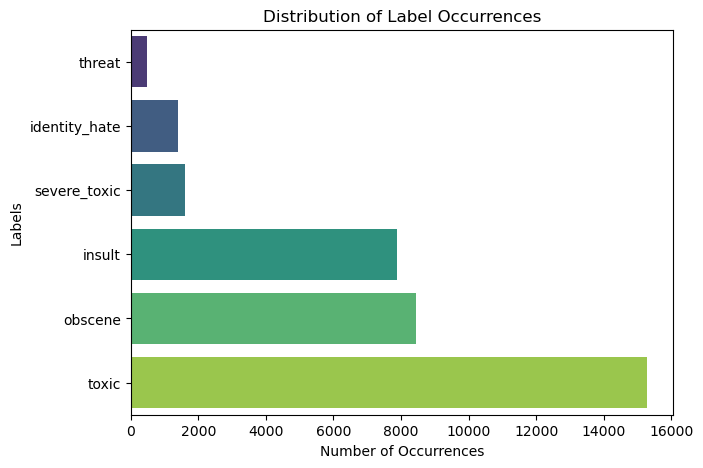

In [11]:
# Visualizing the class distribution of the 'label' column 
column_labels = train_data.columns.tolist()[2:] 
label_counts = train_data[column_labels].sum().sort_values() 


# Create a black background for the plot 
plt.figure(figsize=(7, 5)) 

# Create a horizontal bar plot using Seaborn 
ax = sns.barplot(x=label_counts.values, 
				y=label_counts.index, palette='viridis') 


# Add labels and title to the plot 
plt.xlabel('Number of Occurrences') 
plt.ylabel('Labels') 
plt.title('Distribution of Label Occurrences') 

# Show the plot 
plt.show() 



In [12]:
train_data[column_labels].sum().sort_values()

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64

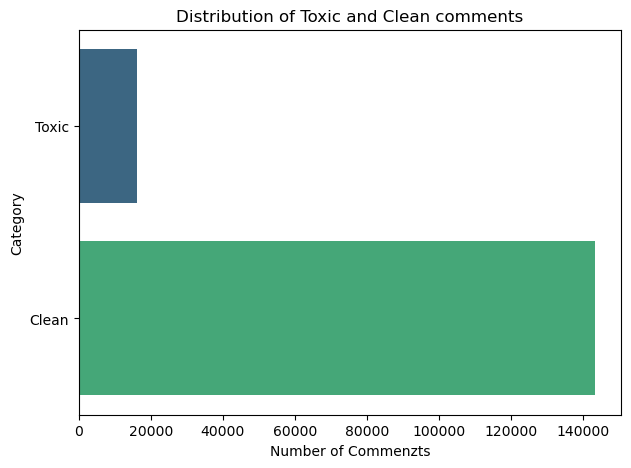

In [13]:
# Create subsets based on toxic and clean comments 
train_toxic = train_data[train_data[column_labels].sum(axis=1) > 0]
train_clean = train_data[train_data[column_labels].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create DataFrame for visualisation
plot_data = pd.DataFrame(
    {'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

plt.figure(figsize = (7,5))

# Horizontal BAR
ax = sns.barplot(x = 'Count', y = 'Category', data = plot_data, palette = 'viridis')

plt.xlabel('Number of Commenzts')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean comments')

ax.tick_params()
plt.show()


In [14]:
print(train_toxic.shape) 
print(train_clean.shape)

(16225, 8)
(143346, 8)


In [15]:
from sklearn.utils import resample
import pandas as pd

# Максимальное количество примеров для любого класса
max_class_count = train_data[column_labels].sum(axis=0).max()

augmented_dataframes = []

# Шаг 1. Аугментация одиночных классов
for label in ["threat", "identity_hate", "severe_toxic", "insult", "obscene", "toxic"]:
    # Выбираем строки, где только данный класс равен 1
    single_class_data = train_data[(train_data[label] == 1) & (train_data[column_labels].sum(axis=1) == 1)]
    
    # Проверяем, есть ли данные для аугментации
    if not single_class_data.empty:
        # Аугментация до max_class_count
        oversampled_class = resample(single_class_data, replace=True, n_samples=max_class_count, random_state=42)
        augmented_dataframes.append(oversampled_class)
    else:
        print(f"No single-class data available for label: {label}")

# Шаг 2. Добавление смешанных классов
# Выбираем строки, где текст относится к нескольким классам
train_toxic_mixed_classes = train_data[train_data[column_labels].sum(axis=1) > 1]
augmented_dataframes.append(train_toxic_mixed_classes)

# Шаг 3. Объединяем все DataFrame
augmented_dataframes = pd.concat(augmented_dataframes, ignore_index=True)

# Шаг 4. Проверяем результат
print("Shape of augmented DataFrame:", augmented_dataframes.shape)
print("Class distribution after augmentation:")
print(augmented_dataframes[column_labels].sum())


No single-class data available for label: severe_toxic
Shape of augmented DataFrame: (86335, 8)
Class distribution after augmentation:
toxic            24922
severe_toxic      1595
obscene          23426
threat           15750
insult           22870
identity_hate    16645
dtype: int64


In [16]:
# Randomly sample 16225 clean comments 
train_clean_sampled = train_clean.sample(n=86335, random_state=42)

# Combine the toxic and the sampled clean comments
dataframe = pd.concat([augmented_dataframes, train_clean_sampled], axis = 0)

#Shuffle the data to avoid any order bias during training
dataframe = dataframe.sample(frac=1, random_state = 42)


In [17]:
dataframe.shape

(172670, 8)

In [18]:
dataframe.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
2772,077576d0a275139a,"Actually, yes, that's what I'm saying. The pro...",0,0,0,0,0,0
17936,ee7d63aae7c7c72f,So the fact Macedonian is a jew and has abusiv...,0,0,0,0,0,1
57250,fe6b0c1e221b997b,"""\n\n Who is Dreadstar and How is it that they...",0,0,1,0,0,0
9760,8fd45641216fdfde,Wikistalking \n\nUnless you wish to be targete...,0,0,0,1,0,0
23817,2a4a8e6efa55ba18,many more Gay Types \n\nthere are many more ty...,0,0,0,0,0,1


In [19]:
# split training data into training_texts, training_labels
train_texts = dataframe.iloc[:, 1] 
train_labels = dataframe.iloc[:, 2:]

In [20]:
print(test_data.isnull().sum())  # missing data in each collumn


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [21]:
print(test_data.iloc[:, 1].shape)  # Форма текстов
print(test_data.iloc[:, 2:].shape)  # Форма меток


(63978,)
(63978, 6)


In [22]:
# Validation set
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,  # Тексты
    train_labels,  # Метки
    test_size=0.25,
    random_state=42
)

print(train_texts.shape)  # Количество текстов в тренировочной выборке
print(train_labels.shape)  # Метки для тренировочной выборки
print(val_texts.shape)  # Количество текстов в валидационной выборке
print(val_labels.shape)  # Метки для валидационной выборки


(129502,)
(129502, 6)
(43168,)
(43168, 6)


In [23]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128): 
    # Initialize empty lists to store tokenized inputs and attention masks 
    input_ids = [] 
    attention_masks = [] 

    # Iterate through each comment in the 'comments' list 
    for comment in comments: 
        # Tokenize and encode the comment using the BERT tokenizer 
        encoded_dict = tokenizer.encode_plus( 
            comment, 

            # Add special tokens like [CLS] and [SEP] 
            add_special_tokens=True, 

            # Truncate or pad the comment to 'max_length' 
            max_length=max_length, 

            truncation=True,

            # Pad the comment to 'max_length' with zeros if needed 
            pad_to_max_length=True, 

            # Return attention mask to mask padded tokens 
            return_attention_mask=True, 

            # Return PyTorch tensors 
            return_tensors='pt'
        ) 

        # Append the tokenized input and attention mask to their respective lists 
        input_ids.append(encoded_dict['input_ids']) 
        attention_masks.append(encoded_dict['attention_mask']) 

    # Concatenate the tokenized inputs and attention masks into tensors 
    input_ids = torch.cat(input_ids, dim=0) 
    attention_masks = torch.cat(attention_masks, dim=0) 

    # Convert the labels to a PyTorch tensor with the data type float32
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels, dtype=torch.float32) 
        
    return input_ids, attention_masks, labels


   

In [24]:
# Token initialisation bert-base-uncased
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True) 

In [25]:
# Model initialisation
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6) 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Model initialisation roberta-base
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
#tokenizer = AutoTokenizer.from_pretrained("roberta-base")
#model_roberta = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=6)

In [27]:
# Model initialisation distilbert-base-uncased
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#model_distilbert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)

In [28]:
# Define the device (MPS for macOS or CPU)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Move model to the device
model = model.to(device) 


Using device: mps


In [29]:
print(type(train_labels))
print(type(test_labels))
#val_labels = val_labels.to_numpy()
print(type(val_labels))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [30]:
# Tokenize and Encode the comments and labels for the training set 
input_ids, attention_masks, labels_tr = tokenize_and_encode( 
	tokenizer, 
	train_texts, 
	train_labels.values 
) 
print('Training Comments :',train_texts.shape) 
print('Input Ids		 :',input_ids.shape) 
print('Attention Mask :',attention_masks.shape) 
print('Labels		 :',len(labels_tr))



# Tokenize and Encode the comments and labels for the test set 
test_input_ids, test_attention_masks, labels_test = tokenize_and_encode( 
	tokenizer, 
	test_texts,
    test_labels.values
) 
print()
print('Test Comments :',test_texts.shape) 
print('Input Ids		 :',test_input_ids.shape) 
print('Attention Mask :',test_attention_masks.shape) 
print('Labels		 :',len(labels_test))



# Tokenize and Encode the comments and labels for the validation set 
val_input_ids, val_attention_masks, labels_val = tokenize_and_encode( 
	tokenizer, 
	val_texts, 
	val_labels.values
)
print()
print('Validation Comments :',val_texts.shape) 
print('Input Ids		 :',val_input_ids.shape) 
print('Attention Mask :',val_attention_masks.shape) 
print('Labels		 :', len(labels_val))

Training Comments : (129502,)
Input Ids		 : torch.Size([129502, 128])
Attention Mask : torch.Size([129502, 128])
Labels		 : 129502

Test Comments : (63978,)
Input Ids		 : torch.Size([63978, 128])
Attention Mask : torch.Size([63978, 128])
Labels		 : 63978

Validation Comments : (43168,)
Input Ids		 : torch.Size([43168, 128])
Attention Mask : torch.Size([43168, 128])
Labels		 : 43168


In [31]:
# Creating DataLoader for the balanced dataset 
batch_size = 64

train_dataset = TensorDataset(input_ids, attention_masks, labels_tr) 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

# testing set 
test_dataset = TensorDataset(test_input_ids, test_attention_masks, labels_test) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

# validation set 
val_dataset = TensorDataset(val_input_ids, val_attention_masks, labels_val) 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 


In [32]:
print('Batch Size :',train_loader.batch_size) 
Batch =next(iter(train_loader)) 
print('Each Input ids shape :',Batch[0].shape) 
print('Input ids :\n',Batch[0][0]) 
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0])) 
print('Corresponding Attention Mask :\n',Batch[1][0]) 
print('Corresponding Label:',Batch[2][0])


Batch Size : 64
Each Input ids shape : torch.Size([64, 128])
Input ids :
 tensor([  101,  4283,  2061,  2172,  2005,  4895, 23467,  2075,  2033,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     

In [33]:
# Optimizer setup 
optimizer = AdamW(model.parameters(), lr=1.11e-5)


In [34]:
class_counts = train_data[column_labels].sum(axis=0)  # Сумма для каждого класса
class_counts

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [35]:
import time
from torch.nn import BCEWithLogitsLoss

# Function to Train the Model
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs, train_data):
    # Start time
    start_time = time.time()

    # Calculate class weights based on the training data
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.max()
    class_weights = class_weights.clip(lower=0.5)
    # Устанавливаем минимальный вес
    class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float).to(device)

    # Initialize weighted loss function
    loss_fn = BCEWithLogitsLoss(pos_weight=class_weights_tensor)

    # Loop through the specified number of epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0

        for batch in train_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Compute loss with class weights
            loss = loss_fn(logits, labels.float())  # Convert labels to float
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [t.to(device) for t in batch]

                # Forward pass
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                # Compute validation loss
                loss = loss_fn(logits, labels.float())
                val_loss += loss.item()

        # Print the average loss for the current epoch
        print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

    # End time
    end_time = time.time()
    print(f"Training time: {end_time - start_time} seconds")


# Call the function to train the model
train_model(model, train_loader, val_loader, optimizer, device, num_epochs=3, train_data=train_data)


Epoch 1, Training Loss: 0.0802446089812882, Validation Loss: 0.03412338454138349
Epoch 2, Training Loss: 0.02830335383304384, Validation Loss: 0.028381155823805817
Epoch 3, Training Loss: 0.021471114150304144, Validation Loss: 0.02529503462422225
Training time: 6938.105712890625 seconds


In [36]:
# Dirrectory for the model
model_save_path = "./saved_model_forth_try"

# Save the model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)


('./saved_model_forth_try/tokenizer_config.json',
 './saved_model_forth_try/special_tokens_map.json',
 './saved_model_forth_try/vocab.txt',
 './saved_model_forth_try/added_tokens.json')

In [37]:
# Load the tokenizer and model from the saved directory 
model_name = model_save_path
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name) 
Bert_Model = BertForSequenceClassification.from_pretrained( 
	model_name).to(device) 


In [38]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device): 
	user_input = [input_text] 

	user_encodings = tokenizer( 
		user_input, truncation=True, padding=True, return_tensors="pt") 

	user_dataset = TensorDataset( 
		user_encodings['input_ids'], user_encodings['attention_mask']) 

	user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False) 

	model.eval() 
	with torch.no_grad(): 
		for batch in user_loader: 
			input_ids, attention_mask = [t.to(device) for t in batch] 
			outputs = model(input_ids, attention_mask=attention_mask) 
			logits = outputs.logits 
			predictions = torch.sigmoid(logits) 

	predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int) 
	labels_list = ['toxic', 'severe_toxic', 'obscene', 
				'threat', 'insult', 'identity_hate'] 
	result = dict(zip(labels_list, predicted_labels[0])) 
	return result 


text = 'Are you insane!'
#predict_user_input(input_text=text) 
print(predict_user_input(input_text=text) )

#predict_user_input(input_text='How are you?') 
print(predict_user_input(input_text='How are you?') )

text = "Such an Idiot person"
predict_user_input(model=Bert_Model, 
				tokenizer=Bert_Tokenizer, 
				input_text=text, 
				device=device) 


{'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


{'toxic': 1,
 'severe_toxic': 0,
 'obscene': 0,
 'threat': 0,
 'insult': 1,
 'identity_hate': 0}

Accuracy: 0.9382
Precision: 0.9607
Recall: 0.9092
Confusion Matrices for Each Class:
Class toxic:
[[36626   348]
 [  769  5425]]
Class severe_toxic:
[[42722    49]
 [  304    93]]
Class obscene:
[[37090   248]
 [  425  5405]]
Class threat:
[[39159    17]
 [   55  3937]]
Class insult:
[[37144   253]
 [  682  5089]]
Class identity_hate:
[[38932    65]
 [  158  4013]]


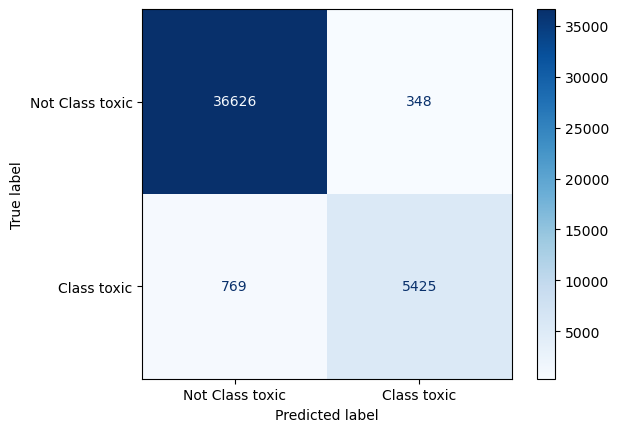

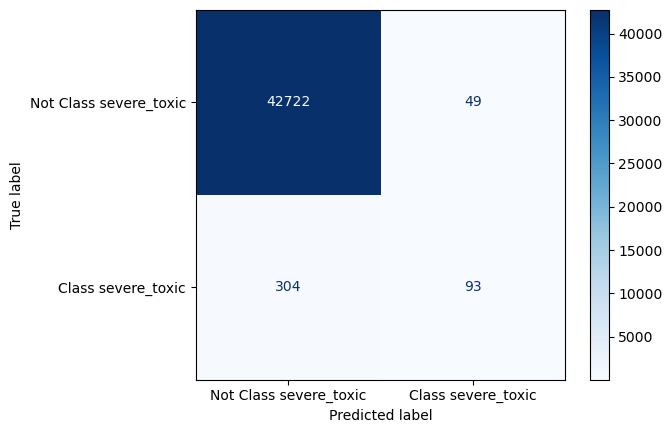

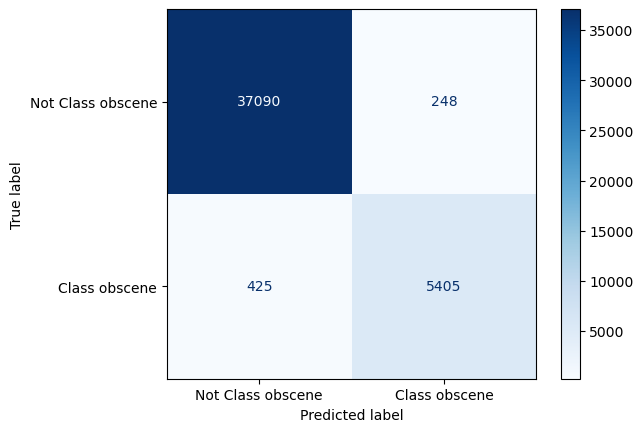

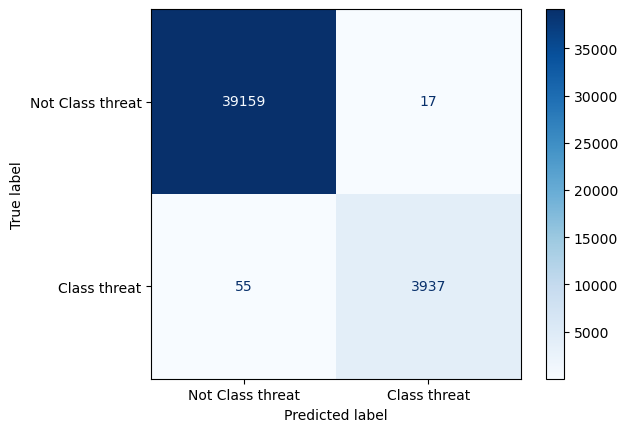

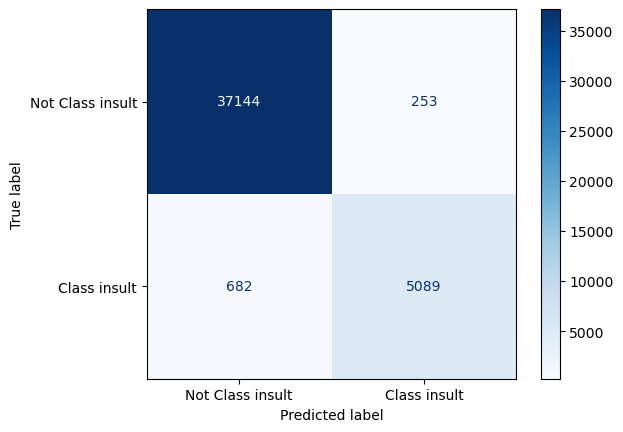

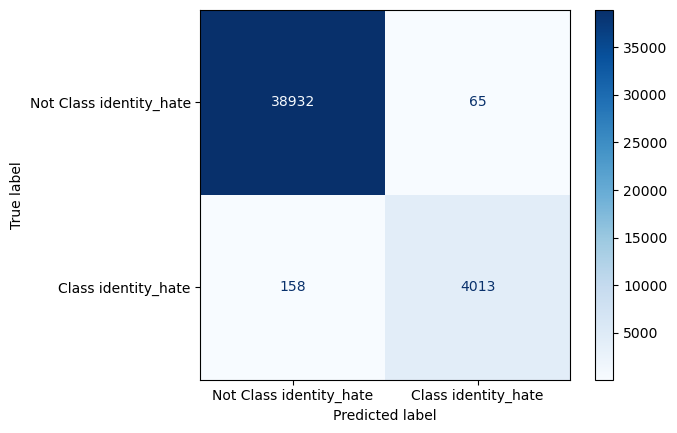

In [55]:
# Model evaluation on the validation data
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay

columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
model = Bert_Model  # Ensure this is defined elsewhere

def evaluate_model(model, loader, device, save_conf_matrix=False, conf_matrix_path="./saved_model_forth_try/confusion_matrix.csv"): 
    model.eval()  # Set the model to evaluation mode 

    true_labels = [] 
    predicted_probs = [] 

    with torch.no_grad(): 
        for batch in loader: 
            input_ids, attention_mask, labels = [t.to(device) for t in batch] 

            # Get model's predictions 
            outputs = model(input_ids, attention_mask=attention_mask) 
            # Use sigmoid for multilabel classification 
            predicted_probs_batch = torch.sigmoid(outputs.logits) 
            predicted_probs.append(predicted_probs_batch.cpu().numpy()) 

            true_labels_batch = labels.cpu().numpy() 
            true_labels.append(true_labels_batch) 

    # Combine predictions and labels for evaluation 
    true_labels = np.concatenate(true_labels, axis=0) 
    predicted_probs = np.concatenate(predicted_probs, axis=0) 
    predicted_labels = (predicted_probs > 0.5).astype(int)  # Apply threshold for binary classification 

    # Calculate evaluation metrics 
    accuracy = accuracy_score(true_labels, predicted_labels) 
    precision = precision_score(true_labels, predicted_labels, average='micro') 
    recall = recall_score(true_labels, predicted_labels, average='micro')
    conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels) 

    # Save confusion matrix to a CSV file if save_conf_matrix is True
    if save_conf_matrix:
        flattened_data = []
        for i, matrix in enumerate(conf_matrix):
            TN, FP = matrix[0]
            FN, TP = matrix[1]
            flattened_data.append({
                'Class': columns[i],
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'TP': TP
            })

        conf_matrix_df = pd.DataFrame(flattened_data)
        conf_matrix_df.to_csv(conf_matrix_path, index=False)

    # Print the evaluation metrics 
    print(f'Accuracy: {accuracy:.4f}') 
    print(f'Precision: {precision:.4f}') 
    print(f'Recall: {recall:.4f}')
    print(f'Confusion Matrices for Each Class:')
    for i, matrix in enumerate(conf_matrix):
        print(f"Class {columns[i]}:\n{matrix}")

    # Display confusion matrices as plots
    for i, matrix in enumerate(conf_matrix):
        disp = ConfusionMatrixDisplay(
            confusion_matrix=matrix, 
            display_labels=[f'Not Class {columns[i]}', f'Class {columns[i]}']
        )
        disp.plot(cmap='Blues')


# Evaluate on val_loader and save the confusion matrix
evaluate_model(model, val_loader, device, save_conf_matrix=True)

Accuracy: 0.8706
Precision: 0.6169
Recall: 0.7162
Confusion Matrices for Each Class:
Class toxic:
[[53663  4225]
 [  816  5274]]
Class severe_toxic:
[[63475   136]
 [  275    92]]
Class obscene:
[[58973  1314]
 [ 1046  2645]]
Class threat:
[[63722    45]
 [  141    70]]
Class insult:
[[59955   596]
 [ 1481  1946]]
Class identity_hate:
[[63135   131]
 [  356   356]]


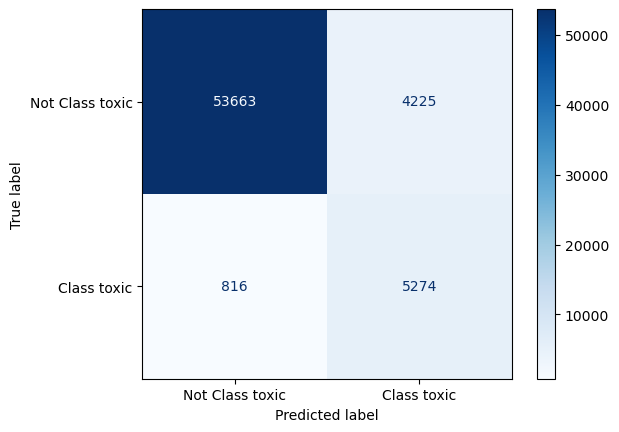

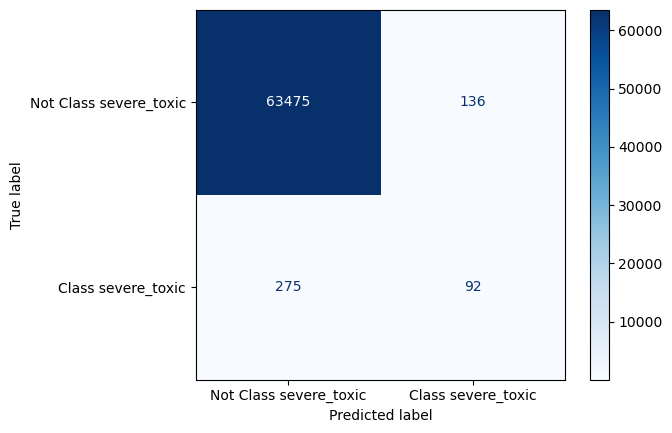

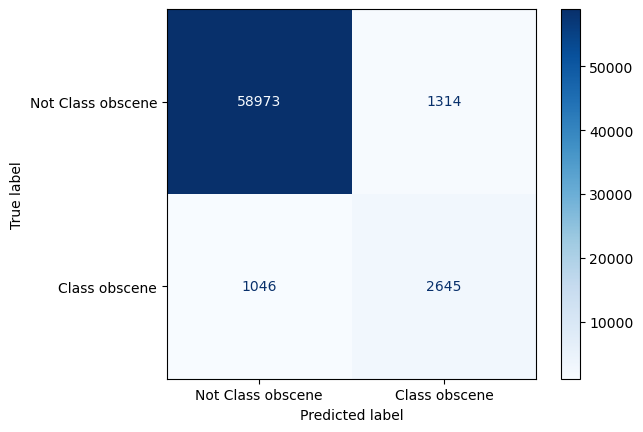

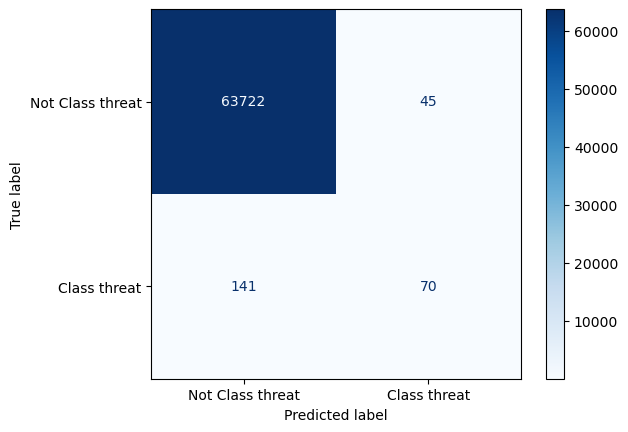

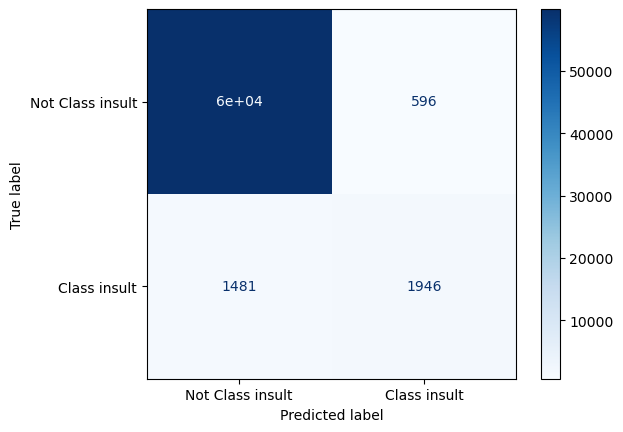

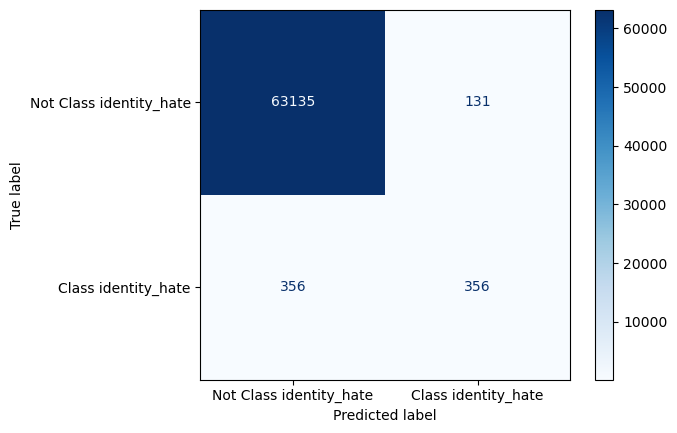

In [56]:
# Evaluate on test_loader without saving the confusion matrix
evaluate_model(model, test_loader, device, save_conf_matrix=False)

In [57]:
#save data for Oleksii 


In [58]:
#val_dataset(TensorDataset)
val_data = val_dataset.tensors # tuple from tensors
val_input_ids, val_attantion_mask, labels_val = map(lambda x: x.numpy(), val_data)
val_df = pd.DataFrame({
    "input_ids": val_input_ids.tolist(),
    "attantion_mask": val_attantion_mask.tolist(),
    "labels": labels_val.tolist()
})

val_df.to_csv("./saved_model_forth_try/val_dataset.csv", index = False)

In [59]:
val_labels[val_labels.columns].sum()

toxic            6194
severe_toxic      397
obscene          5830
threat           3992
insult           5771
identity_hate    4171
dtype: int64

In [60]:
type(train_texts)

pandas.core.series.Series

In [61]:
# Преобразование текстов в DataFrame
train_texts_df = pd.DataFrame({"texts": train_texts})
val_texts_df = pd.DataFrame({"texts": val_texts})

# Проверка на тип меток
if not isinstance(train_labels, pd.DataFrame):
    raise ValueError("train_labels is not a DataFrame. Please ensure correct format.")

if not isinstance(val_labels, pd.DataFrame):
    raise ValueError("val_labels is not a DataFrame. Please ensure correct format.")

# Проверка сумм перед объединением
print("Sum of train_labels before concat:\n", train_labels.sum())
print("Sum of val_labels before concat:\n", val_labels.sum())

# Объединение текстов и меток
train_df = pd.concat([train_texts_df, train_labels], axis=1)
val_df = pd.concat([val_texts_df, val_labels], axis=1)

# Проверка сумм после объединения
print("Sum of train_df labels:\n", train_df[train_labels.columns].sum())
print("Sum of val_df labels:\n", val_df[val_labels.columns].sum())

# Сохранение в CSV
train_df.to_csv("./saved_model_forth_try/train_data.csv", index=False)
val_df.to_csv("./saved_model_forth_try/validation_data.csv", index=False)

Sum of train_labels before concat:
 toxic            18728
severe_toxic      1198
obscene          17596
threat           11758
insult           17099
identity_hate    12474
dtype: int64
Sum of val_labels before concat:
 toxic            6194
severe_toxic      397
obscene          5830
threat           3992
insult           5771
identity_hate    4171
dtype: int64
Sum of train_df labels:
 toxic            18728
severe_toxic      1198
obscene          17596
threat           11758
insult           17099
identity_hate    12474
dtype: int64
Sum of val_df labels:
 toxic            6194
severe_toxic      397
obscene          5830
threat           3992
insult           5771
identity_hate    4171
dtype: int64
